# LSN 10

## Exercise 10.1

Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 10 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

## Exercise 10.2

Apply your parallel code to the TSP problem for 50 american state-capitals longitude and latitude coordinates in the *American_capitals.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Parallel computing adaptation

In order to adapt my code to a **parallel GA** I edited the 
```c++
void GeneticAlgorithm::Evolve()
``` 
method to a 
```c++
void GeneticAlgorithm::ParallelEvolve(int NMigr, MPI_Comm comm, int rank, int size, MPI_Status status)
``` 
This updated method performs the GA search on a number `n` of nodes (continents) independently and every `NMigr` generations it exchanges information regarding the best solution that a certain node has been able to find to another random node. The reason for all this is to further exploit the computation resources of my computer in order to identify an optimal solution in the shortest possible time. Therefore, the structure of my program could be thought as a SPMD with a periodic data sharing.

**Plese note** that another pivotal change has been applied to the `RandomRoutine()` method of the `Random` class: here, we need to have different seeds for different ranks otherwise our distribution of computation over the multiple nodes would be almost pointless, like computing the same thing multiple times. Having said this, i simply customed the previous method creating `RandomRoutineParallel(int rank)` which has the additional feature:
```c++
if (Primes.is_open()){   
      for (int h=0; h < rank+1; h++){
         Primes >> p1 >> p2;
      }
  }
else
      cerr << "PROBLEM: Unable to open Primes" << endl;
  Primes.close();
```

## Parallel with data sharing VS single node research

In order to understand truly the enhancement of this technique i tried running a few tests.
In the plot below I carried out the GA search with an increasing number of nodes up to 10:

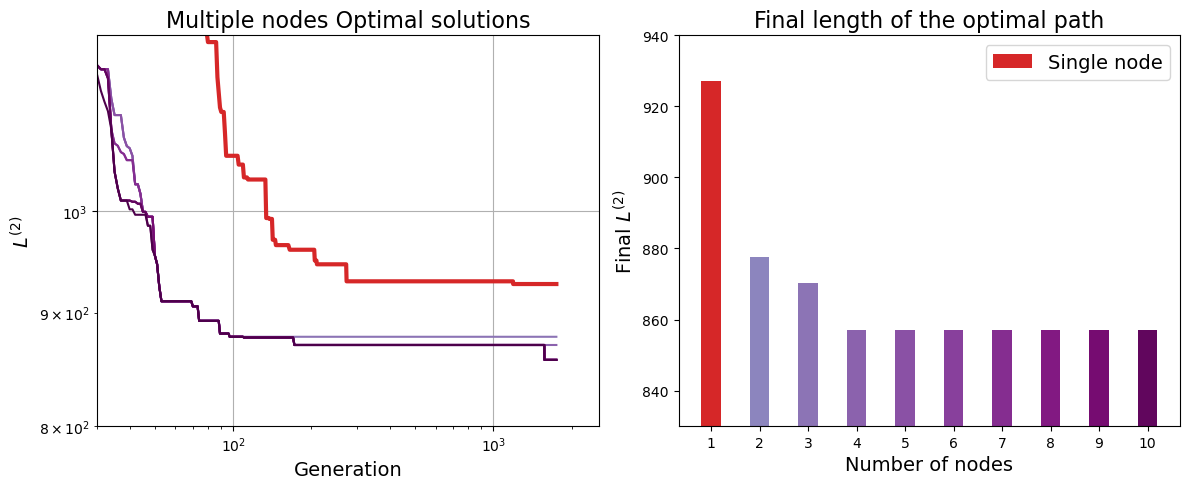

In [880]:
from matplotlib.cm import get_cmap

plt.figure(figsize=(12,5))

# First plot: optimal solutions
plt.subplot(1,2,1)

# It will come in handy for the bar plot
FinalLenghts = []

max=11

cmap = get_cmap('BuPu')
colors = cmap(np.linspace(0.5, 1, max))
#colors = ['tab:red', 'mediumslateblue','mediumpurple','rebeccapurple','blueviolet','indigo','darkorchid','darkviolet','mediumorchid']

# Plot result for single node
serial = np.loadtxt('./10.1/optimumLossSquare.txt', usecols=(0,1))
plt.plot(serial[:1750,1], color='tab:red',lw=3)
FinalLenghts.append(serial[-1,1])

for i in range(2,max):
    folder_name=f'{i}_nodes/'
    losses=[]
    
    for j in range(0, i):
        filename = './10.1/'+folder_name+f'OptimumLossSquareRANK_{j}.txt'
        data = np.loadtxt(filename, usecols=(0,1))
        losses.append(data[:,1])
        
    losses = np.array(losses)
    min_losses = np.min(losses, axis=0)  # Calculate the minimum losses for each x
    FinalLenghts.append(min_losses[-1])
    plt.plot(min_losses, color=colors[i])
    
# Plot configs
plt.xscale('log')
plt.yscale('log')
plt.title('Multiple nodes Optimal solutions', fontsize=16)
plt.xlabel('Generation', fontsize=14)
plt.ylabel('$L^{(2)}$', fontsize=14)
plt.xlim(30)
plt.ylim(800,1200)
plt.grid(True)

# Second plot: barplot with final optimal lengths
plt.subplot(1,2,2)

bar_width = 0.4
r1 = np.arange(max-1) +1
#r2 = [x + bar_width for x in r1]
plt.bar(r1, FinalLenghts, color=colors, width=bar_width)
plt.bar(r1[0], FinalLenghts[0], color='tab:red', width=bar_width, label = 'Single node')
plt.xlabel('Number of nodes', fontsize=14)
plt.ylabel('Final $L^{(2)}$', fontsize=14)
plt.ylim(830, 940)
plt.title('Final length of the optimal path', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(r1, r1)


plt.tight_layout()
plt.show()

For each GA search with a number *n* of nodes, I grouped the results of the different nodes together and for every generation I considered the **best** solution (i.e. the $L^{(2)}$ shortest) retrieved so far by the algorithm that could be find in one of the *n* nodes. 
Therefore, on the left plot we find the results as a function of the number of generations, where the **Single node** reasearch is highlighted in red. Differently, on the right plot we find the **final** values of the shortest path that could be found in any of the *n* nodes used in the reaserch.
All the reasearches were carried out with the following parameters:

- NumberOfChromosomes: $10^4$
- NumberOfGenerations: $1.75\cdot10^3$
- $p_{i}$ (mutations): 2%
- $p_{Cross}$: 90%
- p (exponent loaded die): 8
- $N_{migr}$: 50

The last parameter is the frequency at which information is exchanged between nodes making the research of the different continents dependent of the others.

From the above plot we can clearly see an enhancement in terms of final result. Surely one could argue that this kind of result has come to an additional computational time; however, if we consider the 4-nodes setup we can observe that right after $\simeq100$ generations the length of the optimal path is sensibly shorter than the one found through a single node research.

## How many nodes

My local machine has 8-cores (4 performance cores, 4 efficiency cores) and maybe this is the reason of the plateu we can see in the shortest path starting from 4 nodes. Clearly there is no 1 to 1 association between nodes and cores as my local machine is running many other processes in background.
In terms of computational times, the following barplot shows (NumberOfGenerations=$1500$) the trend we have while increasing nodes:

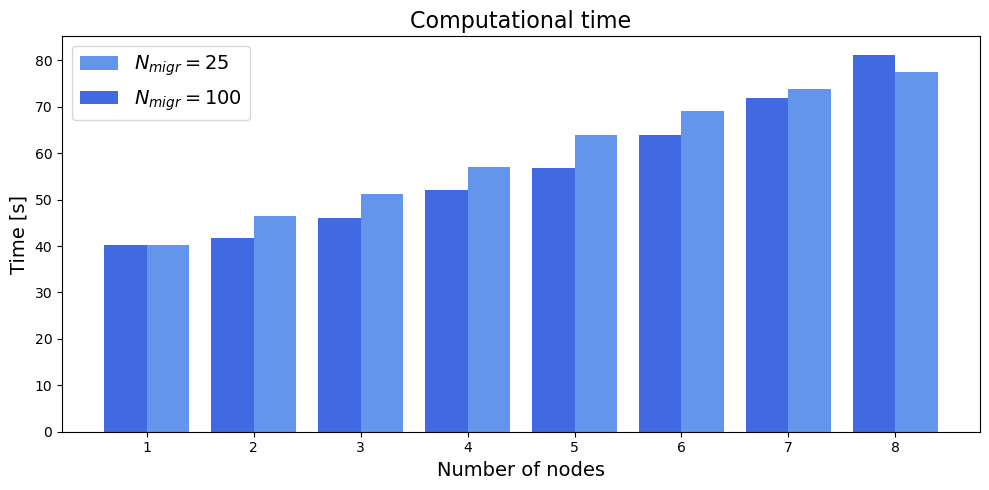

In [881]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from file
data = []
with open('./10.1/performances.txt', 'r') as file:
    for line in file:
        values = line.strip().split(' ')
        data.append([int(values[0]), float(values[1]), float(values[2]),float(values[3]),float(values[4])])

# Extract columns
cores = [row[0] for row in data]
time = [row[1] for row in data]
time2 = [row[3] for row in data]

# Set the positions of the bars on the x-axis
bar_width = 0.4
r1 = np.arange(len(cores))
r2 = [x + bar_width for x in r1]

# Create a figure and two axes objects
fig, ax1 = plt.subplots(figsize=(10,5))

# Plotting on the first y-axis (left side)
ax1.bar(r2, time, color='cornflowerblue', width=bar_width, label='$N_{migr}=25$')
ax1.bar(r1, time2, color='royalblue', width=bar_width, label='$N_{migr}=100$')
ax1.set_xlabel('Number of nodes',fontsize=14)
ax1.set_ylabel('Time [s]',fontsize=14)

# Create a twin axes object sharing the x-axis with ax1


# Customize x-axis ticks and labels
plt.xticks([r + bar_width / 2 for r in range(len(cores))], cores)

# Add legends
ax1.legend(fontsize=14)

plt.title('Computational time', fontsize=16)
plt.tight_layout()
plt.show()


The two bars for each node represent the different migration frequency: one exchange every 25 generations or one every 100. As expected due to parallelization, the computational time doesn't scale linearly with the number of nodes but nearly doubles with 8 nodes.

This is probably enough to convince ourselfs that the parallelization of the algorithm truly brought some enhancements to the solution of our problem.

## INDEPENDENT vs DEPENDENT GA search

We know tackle the comparison between a parallelization with independent GA searches and a parallelization with *migrations* like the one described above. 

Instead of rewriting additional code for the **independent** case I simply tuned $N_{Migr}$ to be $>$`NumberOfGenerations`
so that no message passing happens between nodes. Once again I tried all the configurations starting from 2 nodes to 10 nodes and for each set up I considered the best Optimal solition that could be found among the nodes, as already described. The other parameters used in the GA search are the ones described above.

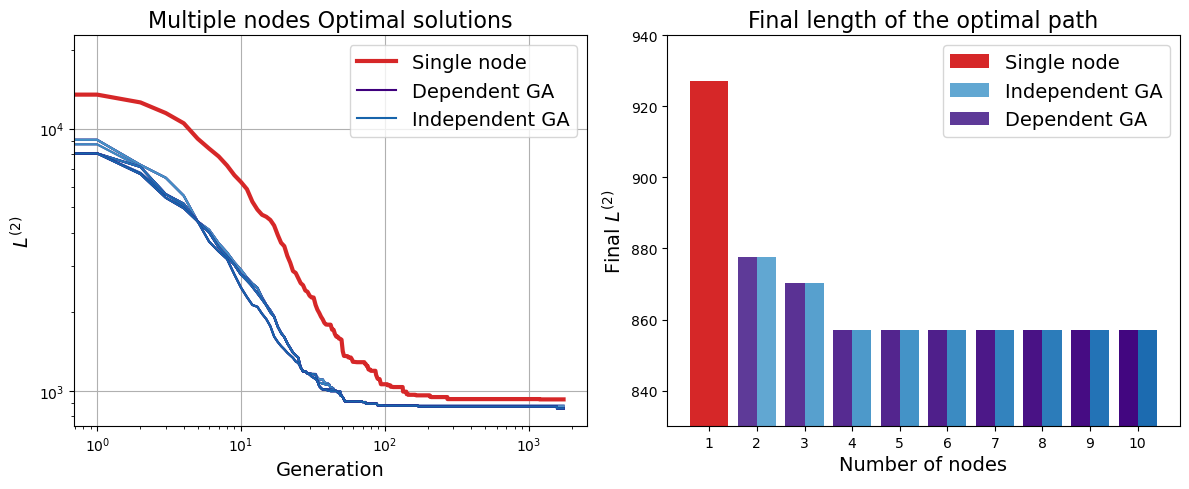

In [882]:
from matplotlib.cm import get_cmap

plt.figure(figsize=(12,5))

# First plot: optimal solutions
plt.subplot(1,2,1)

# It will come in handy for the bar plot
FinalLenghtsDep = []
FinalLenghtsIndep = []

max=11

cmap = get_cmap('Purples')
colorsDep = cmap(np.linspace(0.8, 1, max))
cmap = get_cmap('Blues')
colorsIndep = cmap(np.linspace(0.5, .8, max))

# Plot result for single node
serial = np.loadtxt('./10.1/optimumLossSquare.txt', usecols=(0,1))
plt.plot(serial[:1750,1], color='tab:red',lw=3, label='Single node')
FinalLenghtsDep.append(serial[-1,1])
FinalLenghtsIndep.append(serial[-1,1])

for i in range(2,max):
    folder_nameDep=f'{i}_nodes/'
    lossesDep=[]
    folder_nameIndep=f'{i}_INDEP_nodes/'
    lossesIndep=[]
    
    for j in range(0, i):
        filenameDep = './10.1/'+folder_nameDep+f'OptimumLossSquareRANK_{j}.txt'
        dataDep = np.loadtxt(filenameDep, usecols=(0,1))
        lossesDep.append(dataDep[:,1])
        filenameIndep = './10.1/'+folder_nameIndep+f'OptimumLossSquareRANK_{j}.txt'
        dataIndep = np.loadtxt(filenameIndep, usecols=(0,1))
        lossesIndep.append(dataIndep[:,1])
        
    lossesDep = np.array(lossesDep)
    lossesIndep = np.array(lossesIndep)
    min_lossesDep = np.min(lossesDep, axis=0)  # Calculate the minimum losses for each x
    min_lossesIndep = np.min(lossesIndep, axis=0)  # Calculate the minimum losses for each x
    
    FinalLenghtsDep.append(min_lossesDep[-1])
    FinalLenghtsIndep.append(min_lossesIndep[-1])
    
    plt.plot(min_lossesDep, color=colorsDep[i])
    plt.plot(min_lossesIndep, color=colorsIndep[i])
    
    if (i==10):
        plt.plot(min_lossesDep, color=colorsDep[i], label='Dependent GA')
        plt.plot(min_lossesIndep, color=colorsIndep[i], label='Independent GA')
    

# Plot configs
plt.xscale('log')
plt.yscale('log')
plt.title('Multiple nodes Optimal solutions', fontsize=16)
plt.xlabel('Generation', fontsize=14)
plt.ylabel('$L^{(2)}$', fontsize=14)
plt.grid(which='major')
plt.legend(fontsize=14)

# Second plot: barplot with final optimal lengths
plt.subplot(1,2,2)

bar_width = 0.4
r1 = np.arange(max-1) 
r2 = [x + bar_width for x in r1]

plt.bar(r1, FinalLenghtsDep, color=colorsDep, width=bar_width)
plt.bar(r2, FinalLenghtsIndep, color=colorsIndep, width=bar_width)
plt.bar(r1[0], FinalLenghtsDep[0], color='tab:red', width=bar_width, label = 'Single node')
plt.bar(r2[0], FinalLenghtsIndep[0], color='tab:red', width=bar_width)
plt.bar(r2[1], FinalLenghtsIndep[1], color=colorsIndep[1], width=bar_width, label='Independent GA')
plt.bar(r1[1], FinalLenghtsDep[1], color=colorsDep[1], width=bar_width, label='Dependent GA')

# Configs
plt.xlabel('Number of nodes', fontsize=14)
plt.ylabel('Final $L^{(2)}$', fontsize=14)
plt.ylim(830, 940)
plt.title('Final length of the optimal path', fontsize=16)
plt.legend(fontsize=14)
# Customize x-axis ticks and labels
plt.xticks([r + bar_width / 2 for r in range(len(r1))], r1+1)

plt.tight_layout()
plt.show()

On the left are shown the results for the averages of best half of the population while on the right the optimal solution at a given generation is depicted. For the multi node setup, the plot shows the **minimum** of the average of the best half of the population **among the 5 nodes** and similarly the **maximum** and the **average**. Similarly, on the Optimal solution plot, there are shown the minimum of the optimal solution across the 5 nodes, the corresponfing maximum and the average.


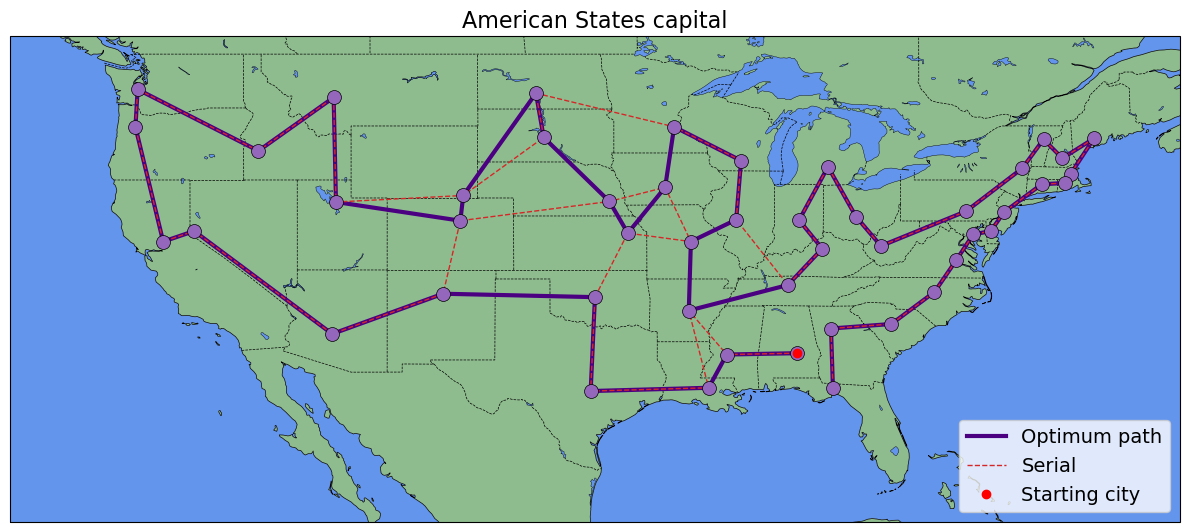

In [884]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Read the city coordinates from the file
city_coordinates = {}
with open('American_capitals.dat', 'r') as file:
    next(file)  # Skip the first line
    for line in file:
        name = line.strip().split('\t')[0]
        latitude = line.strip().split()[-1]
        longitude = line.strip().split()[-2]
        city_coordinates[name] = (float(longitude), float(latitude))
        

# Create a Cartopy map of the United States
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -65, 23, 50], crs=ccrs.PlateCarree())

#Load the solution I found through GA
serialPath = np.loadtxt('../LSN_9/9.1/pathsCapitals.txt', usecols=(0, 1, 2))
lastPathSerial=serialPath[serialPath[:,0]==2975]

path = np.loadtxt('./10.1/4_nodes/pathsSquareRANK_3.txt', usecols=(0, 1, 2))
lastPath=path[path[:,0]==1725]

#Add states borders
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Add map features
ax.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
ax.add_feature(cfeature.LAND, facecolor='darkseagreen')
ax.add_feature(cfeature.COASTLINE, color='black', lw=0.5)
ax.add_feature(cfeature.BORDERS, ls='--', lw=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black',facecolor='cornflowerblue', linewidth=0.3)
ax.add_feature(states_provinces, ls='--', lw=0.5)

#plot path
ax.plot(lastPath[:,1],lastPath[:,2], color='indigo', label='Optimum path', lw=3)
ax.plot(lastPathSerial[:,1],lastPathSerial[:,2], color='tab:red', label='Serial', lw=1, ls='--')

# Plot the cities on the map
for city, (lon, lat) in city_coordinates.items():
    ax.plot(lon, lat, 'o', color='tab:purple', mec='black',mew=0.5, markersize=10, transform=ccrs.PlateCarree())


#starting city
(lon,lat) = city_coordinates['Alabama ']
ax.plot(lon, lat, 'ro', label='Starting city')

# Show the map
plt.title('American States capital',fontsize=16)
plt.legend(fontsize=14, loc='lower right')
plt.tight_layout()
         
plt.show()

The above plot shows the best Optimum path found across one node of the 4-nodes setup and the one retrieved by the single search GA. It is quite clear how on the central-west coast portion of the path, the serial GA search is outperformed by the multiple nodes setup.

## Conclusions

Clearly, parallel computing brought significant enhancements to the GA search if compared to the single-node setup and probabily the last map captures this situation.
Nonetheless, with the results I obtained in the 48-cities GA search, I was unable of spotting a significant difference between the independent and dependedent research in terms of the best solution produced across the nodes for our search problem. However, I thought that differences might be highlighted when facing a very difficult problem, i.e. a TSP with 100 cities ($100!$ combinations, $\simeq 10^{157}$). Therefore I reproduced the same comparison plots as above with `NumberOfGenerations`=5000 and eventually spotted some performance differences between the dependent and independent GA search.

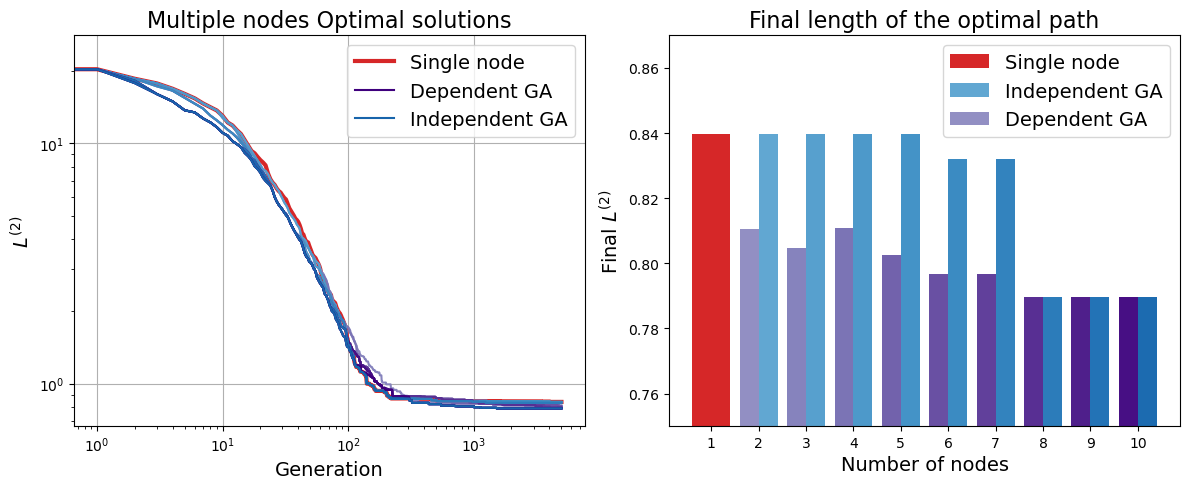

In [885]:
from matplotlib.cm import get_cmap

plt.figure(figsize=(12,5))

# First plot: optimal solutions
plt.subplot(1,2,1)

# It will come in handy for the bar plot
FinalLenghtsDep = []
FinalLenghtsIndep = []

max=11

cmap = get_cmap('Purples')
colorsDep = cmap(np.linspace(0.5, 1, max))

cmap = get_cmap('Blues')
colorsIndep = cmap(np.linspace(0.5, .8, max))

# Plot result for single node
serial = np.loadtxt('./10.1/optimumLossSquare100.txt', usecols=(0,1))
plt.plot(serial[:,1], color='tab:red',lw=3, label='Single node')
FinalLenghtsDep.append(serial[-1,1])
FinalLenghtsIndep.append(serial[-1,1])

for i in range(2,max):
    folder_nameDep=f'{i}_dep_100/'
    lossesDep=[]
    folder_nameIndep=f'{i}_indep_100/'
    lossesIndep=[]
    
    for j in range(0, i):
        filenameDep = './10.1/'+folder_nameDep+f'OptimumLossSquareRANK_{j}.txt'
        dataDep = np.loadtxt(filenameDep, usecols=(0,1))
        lossesDep.append(dataDep[:,1])
        filenameIndep = './10.1/'+folder_nameIndep+f'OptimumLossSquareRANK_{j}.txt'
        dataIndep = np.loadtxt(filenameIndep, usecols=(0,1))
        lossesIndep.append(dataIndep[:,1])
        
    lossesDep = np.array(lossesDep)
    lossesIndep = np.array(lossesIndep)
    min_lossesDep = np.min(lossesDep, axis=0)  # Calculate the minimum losses for each x
    min_lossesIndep = np.min(lossesIndep, axis=0)  # Calculate the minimum losses for each x
    
    FinalLenghtsDep.append(min_lossesDep[-1])
    FinalLenghtsIndep.append(min_lossesIndep[-1])
    
    plt.plot(min_lossesDep, color=colorsDep[i])
    plt.plot(min_lossesIndep, color=colorsIndep[i])
    
    if (i==10):
        plt.plot(min_lossesDep, color=colorsDep[i], label='Dependent GA')
        plt.plot(min_lossesIndep, color=colorsIndep[i], label='Independent GA')
    

# Plot configs
plt.xscale('log')
plt.yscale('log')
plt.title('Multiple nodes Optimal solutions', fontsize=16)
plt.xlabel('Generation', fontsize=14)
plt.ylabel('$L^{(2)}$', fontsize=14)
plt.grid(which='major')
plt.legend(fontsize=14)

# Second plot: barplot with final optimal lengths
plt.subplot(1,2,2)

bar_width = 0.4
r1 = np.arange(max-1) 
r2 = [x + bar_width for x in r1]

plt.bar(r1, FinalLenghtsDep, color=colorsDep, width=bar_width)
plt.bar(r2, FinalLenghtsIndep, color=colorsIndep, width=bar_width)
plt.bar(r1[0], FinalLenghtsDep[0], color='tab:red', width=bar_width, label = 'Single node')
plt.bar(r2[0], FinalLenghtsIndep[0], color='tab:red', width=bar_width)
plt.bar(r2[1], FinalLenghtsIndep[1], color=colorsIndep[1], width=bar_width, label='Independent GA')
plt.bar(r1[1], FinalLenghtsDep[1], color=colorsDep[1], width=bar_width, label='Dependent GA')

# Configs
plt.xlabel('Number of nodes', fontsize=14)
plt.ylabel('Final $L^{(2)}$', fontsize=14)
plt.title('Final length of the optimal path', fontsize=16)
plt.legend(fontsize=14)
plt.ylim(0.75,0.87)
# Customize x-axis ticks and labels
plt.xticks([r + bar_width / 2 for r in range(len(r1))], r1+1)

plt.tight_layout()
plt.show()

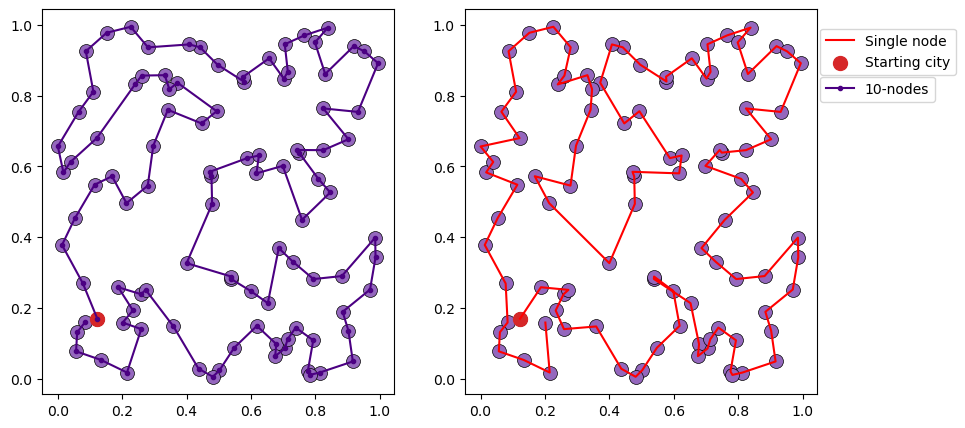

In [887]:
cities = np.loadtxt('./10.1/capitals100.txt', usecols=(0, 1))
pathSquareTen = np.loadtxt('./10.1/10_dep_100/pathsSquareRANK_0.txt', usecols=(0, 1, 2))

pathSquareSingle = np.loadtxt('./10.1/pathsSquare100txt', usecols=(0, 1, 2))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

frame = pathSquareTen[pathSquareTen[:, 0] == 4975]
plt.plot(frame[:, 1], frame[:, 2],'o-', mfc='indigo',ms=3, color='indigo', label='10-nodes')
plt.scatter(cities[:, 0], cities[:, 1], color='tab:purple', s=100, linewidths=0.5, edgecolors='black')
plt.scatter(cities[0, 0], cities[0, 1], c='tab:red', s=100)
plt.legend(loc=(2.21,0.76))

plt.subplot(1,2,2)
frame = pathSquareSingle[pathSquareSingle[:, 0] == 4975]
plt.plot(frame[:, 1], frame[:, 2], color='red', label='Single node')
plt.scatter(cities[:, 0], cities[:, 1], color='tab:purple', s=100, linewidths=0.5, edgecolors='black')
plt.scatter(cities[0, 0], cities[0, 1], c='tab:red', s=100, label='Starting city')
plt.legend(loc=(1.01,0.83))

plt.show()